In [1]:
!pip install afinn
from afinn import Afinn

import PyPDF2
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import os

import textract

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from transformers import BertTokenizer, BertModel, AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
import numpy as np

import PyPDF2
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import os


[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/work/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing and Preliminary analyses

In [2]:
folder_path = '/work/ElisabetSkovgaardVick#9298/loop_data'
# Initialize a dictionary to store text for each file
all_texts = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.pdf'):
        file_path = os.path.join(folder_path, filename)

        # Open the PDF file
        with open(file_path, 'rb') as pdfFileObj:
            # Create a PDF reader object
            pdfReader = PyPDF2.PdfReader(pdfFileObj)

            # Get the total number of pages
            total_pages = len(pdfReader.pages)

            # Initialize variables for counting and storing text
            count = 0
            text = ''

            # Loop through each page in the PDF file
            while count < total_pages:
                # Get the specified page in the document
                current_page = pdfReader.pages[count]

                # Process the current page
                count += 1

                # Extract the text from the page and append to the overall text
                text += current_page.extract_text()

            # Store the text in the dictionary using the filename as the key
            all_texts[filename] = text

In [3]:
# Convert the dictionary to a DataFrame
df_post_texts = pd.DataFrame(list(all_texts.items()), columns=['filename', 'text'])

# Save the DataFrame to a CSV file
df_post_texts.to_csv('/work/ElisabetSkovgaardVick#9298/exam_data/post_data.csv', index=False, escapechar='\\')

In [4]:
folder_path1 = '/work/ElisabetSkovgaardVick#9298/loop_data1'
# Initialize a dictionary to store text for each file
all_texts1 = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path1):
    if filename.endswith('.pdf'):
        file_path1 = os.path.join(folder_path1, filename)

        # Open the PDF file
        with open(file_path1, 'rb') as pdfFileObj:
            # Create a PDF reader object
            pdfReader = PyPDF2.PdfReader(pdfFileObj)

            # Get the total number of pages
            total_pages = len(pdfReader.pages)

            # Initialize variables for counting and storing text
            count = 0
            text = ''

            # Loop through each page in the PDF file
            while count < total_pages:
                # Get the specified page in the document
                current_page = pdfReader.pages[count]

                # Process the current page
                count += 1

                # Extract the text from the page and append to the overall text
                text += current_page.extract_text()

            # Store the text in the dictionary using the filename as the key
            all_texts1[filename] = text

In [5]:
# Convert the dictionary to a DataFrame
df_præ_texts = pd.DataFrame(list(all_texts1.items()), columns=['filename', 'text'])

# Save the DataFrame to a CSV file
df_præ_texts.to_csv('/work/ElisabetSkovgaardVick#9298/exam_data/præ_data.csv', index=False, escapechar='\\')

In [6]:
df_post = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/post_data.csv')
df_præ = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/præ_data.csv')

In [7]:
# Loop through each text in the dictionary and convert to lowercase
for filename, text in all_texts.items():
    # Convert text to lowercase
    lowercased_text = text.lower()

    # Update the text in the dictionary with the lowercase version
    all_texts[filename] = lowercased_text

# Loop through each text in the dictionary and convert to lowercase
for filename, text in all_texts1.items():
    # Convert text to lowercase
    lowercased_text1 = text.lower()

    # Update the text in the dictionary with the lowercase version
    all_texts1[filename] = lowercased_text1

In [8]:
def clean_text(lowercased_text):
    # split text phrases into words
    words = nltk.word_tokenize(lowercased_text)

    # Create a list of all the punctuations we wish to remove
    punctuations = ['.', ',', '/', '!', '?', ';', ':', '(', ')', '[', ']', '-', '_', '%', '§']

    # Remove all the special characters
    lower_case = re.sub(r'\W', ' ', str(lowercased_text))

    stop_words1 = ('tiltalte', 'og', 'har', 'på', 'forurettede', 'er', 'retten', 'af', 'som', 'ved', 'jf', 'kl', 'nr', 'han', 'hun', 'det', 'var', 'ikke', 'til', 'med', 'en', 'der', 'om', 'at', 'i', 'de', 'havde', 'den', 'hende', 'men', 'et', 'fra', 'blev', 'efter', 'sig', 'skulle', 'via')

    # Getting rid of all the words that contain numbers in them
    words_without_numbers = [word for word in words if not any(char.isdigit() for char in word)]

    # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lowercased_text)

    # Substituting multiple spaces with a single space
    lower_case = re.sub(r'\s+', ' ', lowercased_text, flags=re.I)

    # Creating a list of keywords based on specified conditions
    keywords = [word for word in words_without_numbers if word not in stop_words1 and word not in punctuations]

    return keywords


def clean_text(lowercased_text1):
    # split text phrases into words
    words1 = nltk.word_tokenize(lowercased_text1)

    # Create a list of all the punctuations we wish to remove
    punctuations = ['.', ',', '/', '!', '?', ';', ':', '(', ')', '[', ']', '-', '_', '%', '§']

    # Remove all the special characters
    lower_case = re.sub(r'\W', ' ', str(lowercased_text1))

    stop_words1 = ('tiltalte', 'og', 'har', 'på', 'forurettede', 'er', 'retten', 'af', 'som', 'ved', 'jf', 'kl', 'nr', 'han', 'hun', 'det', 'var', 'ikke', 'til', 'med', 'en', 'der', 'om', 'at', 'i', 'de', 'havde', 'den', 'hende', 'men', 'et', 'fra', 'blev', 'efter', 'sig', 'skulle', 'via')

    # Getting rid of all the words that contain numbers in them
    words_without_numbers = [word for word in words1 if not any(char.isdigit() for char in word)]

    # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lowercased_text1)

    # Substituting multiple spaces with a single space
    lower_case = re.sub(r'\s+', ' ', lowercased_text1, flags=re.I)

    # Creating a list of keywords based on specified conditions
    keywords = [word for word in words_without_numbers if word not in stop_words1 and word not in punctuations]

    return keywords

In [9]:
nltk.download('wordnet')

def lemmatize_text(lowercased_text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in lowercased_text]
    return ' '.join(lemmatized_words)


# Loop through each text in the dictionary
for filename, lowercased_text in all_texts.items():
    # Apply cleaning
    cleaned_keywords = clean_text(lowercased_text)

    # Apply lemmatization
    lemmatized_text = lemmatize_text(cleaned_keywords)


print(lemmatized_text)
all_texts[filename] = lemmatized_text

nltk.download('wordnet')

def lemmatize_text(lowercased_text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in lowercased_text]
    return ' '.join(lemmatized_words)


# Loop through each text in the dictionary
for filename, lowercased_text1 in all_texts1.items():
    # Apply cleaning
    cleaned_keywords1 = clean_text(lowercased_text1)

    # Apply lemmatization
    lemmatized_text1 = lemmatize_text(cleaned_keywords1)


print(lemmatized_text1)
all_texts1[filename] = lemmatized_text1

[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...


glostrup udskrift dombogen d o m afsagt maj rettens politiets anklagemyndigheden mod cpr født denne sag behandlet tilståelsessag retsmødebegæring modtaget december sagen medfør retsplejelovens stk behandlet for lukkede døre tiltalt for overtrædelse straf felovens stk perioden september april da år t iktok snapchat go-ogle meet flere gange fået vise sine bryster holdt sine hænder op foran herefter have tvunget gøre sagde idet ellers ville dele billeder opnå-et hvorefter tvang fremvise sin skede hvor indførte finger idet ellers ville dele film optaget sendt hendes mor straf felovens blufærdighedskrænkelse perioden september april da år t iktok snapchat google meet fået vise sine bryster holdt sine hænder op foran herefter have tvunget gøre sagde idet ellers ville dele billeder opnået hvorefter tvang fremvise sin skede hvor indførte finger idet ellers ville dele film optaget hav-de sendt hendes mor hvilket egnet krænke hendes blufærdighed straf felovens perioden september april da år have

[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
afinn = Afinn(language='da')

for lemmatized_text in all_texts.values():
    # Perform sentiment analysis on each lemmatized text
    score = afinn.score(lemmatized_text)
    
    # Print the filename and sentiment score
    print(f"Sentiment score for filename: {score}")



for lemmatized_text1 in all_texts1.values():
    # Perform sentiment analysis on each lemmatized text
    score1 = afinn.score(lemmatized_text1)
    
    # Print the filename and sentiment score
    print(f"Sentiment score for filename: {score1}")

Sentiment score for filename: -26.0
Sentiment score for filename: -827.0
Sentiment score for filename: -179.0
Sentiment score for filename: -597.0
Sentiment score for filename: -1476.0
Sentiment score for filename: -1492.0
Sentiment score for filename: -35.0
Sentiment score for filename: -551.0
Sentiment score for filename: -220.0
Sentiment score for filename: -1318.0
Sentiment score for filename: -37.0
Sentiment score for filename: -1168.0
Sentiment score for filename: -94.0
Sentiment score for filename: -131.0
Sentiment score for filename: -1538.0
Sentiment score for filename: -29.0
Sentiment score for filename: -1463.0
Sentiment score for filename: -421.0
Sentiment score for filename: -226.0
Sentiment score for filename: -163.0
Sentiment score for filename: -10.0
Sentiment score for filename: -36.0
Sentiment score for filename: -43.0
Sentiment score for filename: -238.0
Sentiment score for filename: -14.0
Sentiment score for filename: -170.0
Sentiment score for filename: -64.0
Senti

                   sentiment_score                                          \
                             count        mean         std     min     25%   
sentiment_category                                                           
negative                     131.0 -559.366412  845.521298 -5752.0 -702.50   
positive                       2.0  326.500000  449.012806     9.0  167.75   

                                          
                      50%     75%    max  
sentiment_category                        
negative           -223.0  -53.50   -6.0  
positive            326.5  485.25  644.0  


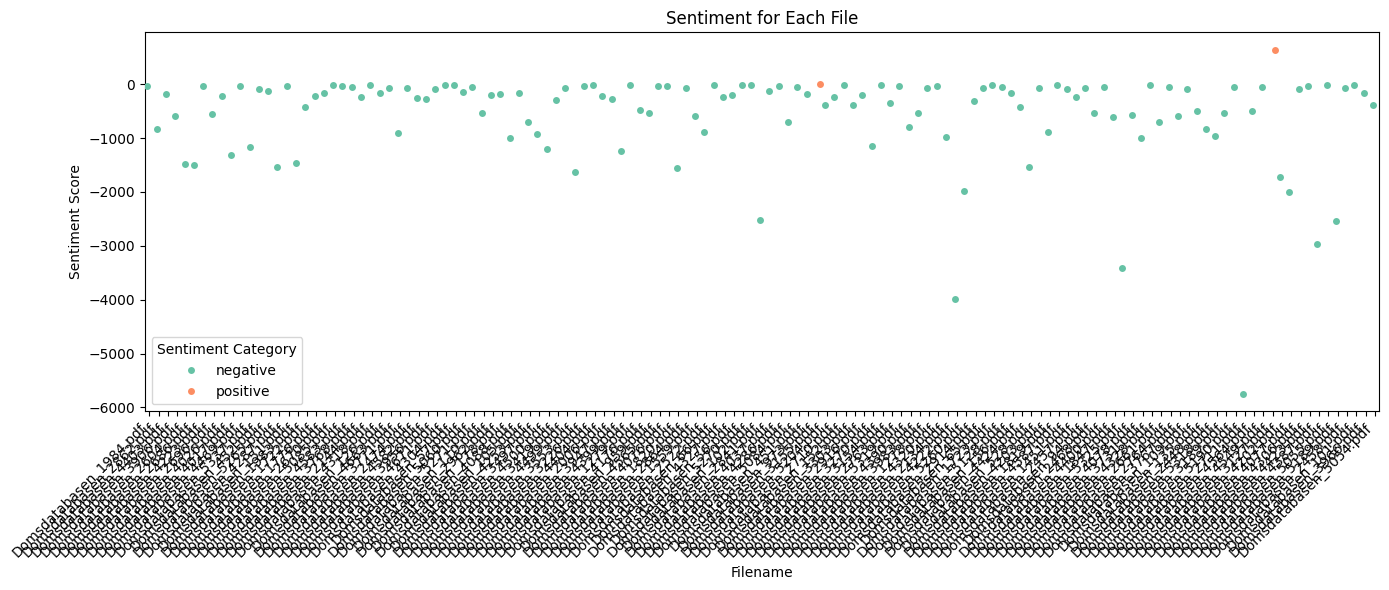

In [11]:
from afinn import Afinn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_texts' is a dictionary where keys are filenames and values are lemmatized text
afinn = Afinn(language='da')

# Compute sentiment scores (polarity) and labels
sentiment_scores = [afinn.score(lemmatized_text) for lemmatized_text in all_texts.values()]
sentiment_category = ['positive' if score > 0 
                      else 'negative' if score < 0 
                      else 'neutral' 
                      for score in sentiment_scores]

# Create a DataFrame
df = pd.DataFrame(list(zip(all_texts.keys(), sentiment_scores, sentiment_category)), columns=['filename', 'sentiment_score', 'sentiment_category'])
df['sentiment_score'] = df['sentiment_score'].astype(float)

# Sentiment statistics per news category
category_stats = df.groupby(by=['sentiment_category']).describe()

# Display the DataFrame with sentiment statistics
print(category_stats)

# Plotting each file's sentiment
plt.figure(figsize=(14, 6))
sns.stripplot(x='filename', y='sentiment_score', hue='sentiment_category', data=df, jitter=True, dodge=True, palette="Set2")
plt.title('Sentiment for Each File')
plt.xlabel('Filename')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

                   sentiment_score                                          \
                             count        mean         std     min     25%   
sentiment_category                                                           
negative                      49.0 -131.836735  204.106625 -1133.0 -149.00   
neutral                        7.0    0.000000    0.000000     0.0    0.00   
positive                       2.0  291.500000  393.858477    13.0  152.25   

                                          
                      50%     75%    max  
sentiment_category                        
negative            -64.0  -32.00   -2.0  
neutral               0.0    0.00    0.0  
positive            291.5  430.75  570.0  


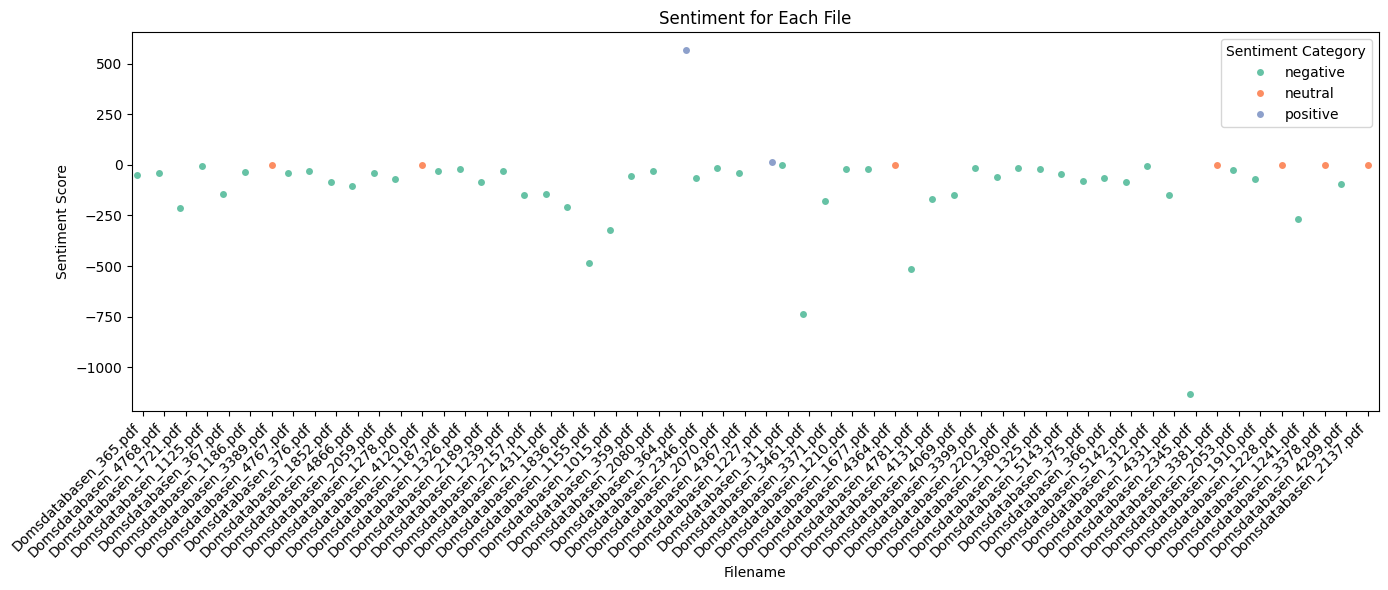

In [12]:
from afinn import Afinn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_texts' is a dictionary where keys are filenames and values are lemmatized text
afinn = Afinn(language='da')

# Compute sentiment scores (polarity) and labels
sentiment_scores = [afinn.score(lemmatized_text1) for lemmatized_text1 in all_texts1.values()]
sentiment_category = ['positive' if score > 0 
                      else 'negative' if score < 0 
                      else 'neutral' 
                      for score in sentiment_scores]

# Create a DataFrame
df1 = pd.DataFrame(list(zip(all_texts1.keys(), sentiment_scores, sentiment_category)), columns=['filename', 'sentiment_score', 'sentiment_category'])
df1['sentiment_score'] = df1['sentiment_score'].astype(float)

# Sentiment statistics per file
category_stats1 = df1.groupby(by=['sentiment_category']).describe()

# Display the DataFrame with sentiment statistics
print(category_stats1)

# Plotting each file's sentiment
plt.figure(figsize=(14, 6))
sns.stripplot(x='filename', y='sentiment_score', hue='sentiment_category', data=df1, jitter=True, dodge=True, palette="Set2")
plt.title('Sentiment for Each File')
plt.xlabel('Filename')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

In [13]:
df.to_csv('/work/ElisabetSkovgaardVick#9298/exam_data/sentiment_data_post.csv', index=False)
df1.to_csv('/work/ElisabetSkovgaardVick#9298/exam_data/sentiment_data_præ.csv', index=False)


                 filename  sentiment_score sentiment_category dataset
0  Domsdatabasen_1984.pdf            -26.0           negative    Post
1  Domsdatabasen_2862.pdf           -827.0           negative    Post
2  Domsdatabasen_4403.pdf           -179.0           negative    Post
3  Domsdatabasen_3906.pdf           -597.0           negative    Post
4  Domsdatabasen_2604.pdf          -1476.0           negative    Post


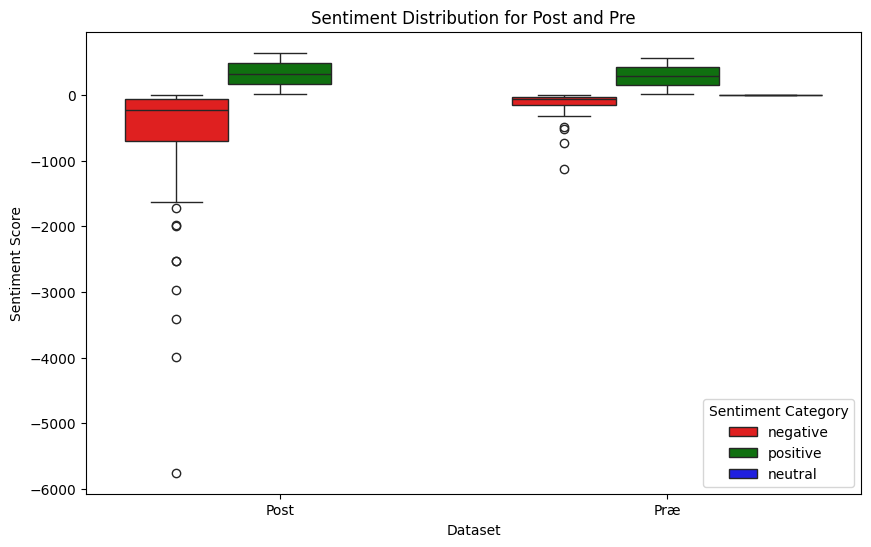

/tmp/ipykernel_2187/3229582797.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y='sentiment_score', data=df_combined, palette={"Post": "purple", "Præ": "blue"})


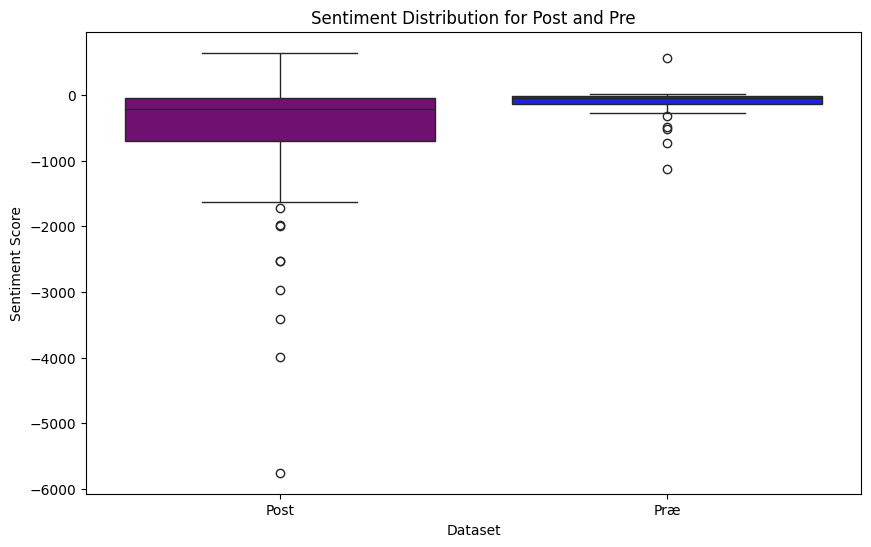

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets from the CSV files
df_post = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/sentiment_data_post.csv')
df_præ = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/sentiment_data_præ.csv')

# Add a 'dataset' column to identify the datasets
df_post['dataset'] = 'Post'
df_præ['dataset'] = 'Præ'

# Concatenate the two datasets
df_combined = pd.concat([df_post, df_præ])

# Display the combined DataFrame
print(df_combined.head())

# Create a boxplot with x='dataset' and hue='sentiment_category'
plt.figure(figsize=(10, 6))
sns.boxplot(x='dataset', y='sentiment_score', hue='sentiment_category', data=df_combined, palette={"positive": "green", "negative": "red", "neutral": "blue"})
plt.title('Sentiment Distribution for Post and Pre')
plt.xlabel('Dataset')
plt.ylabel('Sentiment Score')
plt.legend(title='Sentiment Category')
plt.show()

# Create a boxplot with x='dataset' for the entire data
plt.figure(figsize=(10, 6))

# Include keys 'Post' and 'Præ' in the palette dictionary
sns.boxplot(x='dataset', y='sentiment_score', data=df_combined, palette={"Post": "purple", "Præ": "blue"})
plt.title('Sentiment Distribution for Post and Pre')
plt.xlabel('Dataset')
plt.ylabel('Sentiment Score')
plt.show()

In [15]:
from scipy.stats import ttest_ind

post_scores = df_combined[df_combined['dataset'] == 'Post']['sentiment_score']
præ_scores = df_combined[df_combined['dataset'] == 'Præ']['sentiment_score']

t_statistic, p_value = ttest_ind(post_scores, præ_scores)
print(f"T-Statistic: {t_statistic}, P-Value: {p_value}")

print(len(df_combined))

T-Statistic: -3.939646312523178, P-Value: 0.000114738638288974
191


In [16]:
import pandas as pd
df_post = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/post_data.csv')
df_præ = pd.read_csv('/work/ElisabetSkovgaardVick#9298/exam_data/præ_data.csv')

# Add a 'label' column
df_post['label'] = 1  # 1 for 'Post'
df_præ['label'] = 0   # 0 for 'Præ'

# Concatenate the two datasets
df_combined = pd.concat([df_post, df_præ])

texts = df_combined['text'].tolist()
labels = df_combined['label'].tolist()

df_combined = df_combined.dropna(subset=['text'])
df_combined

,filename,text,label
0,Domsdatabasen_1984.pdf,/4 års fængsel i sag om overtrædelse af omfatt...,1
1,Domsdatabasen_2862.pdf,/\nRETTEN I KOLDING\nDOM\nafsagt den 12. janua...,1
2,Domsdatabasen_4403.pdf,/D O M\nafsagt den 6. juli 2023 af V estre Lan...,1
3,Domsdatabasen_3906.pdf,/\nRETTEN I HOLSTEBRO\nUdskrift af dombogen\nD...,1
4,Domsdatabasen_2604.pdf,/\nRETTEN I NYKØBING F .\nUdskrift af dombogen...,1
...,...,...,...
51,Domsdatabasen_2053.pdf,/\nRETTEN I HOLBÆK\nDen 6. december 2013 kl. 1...,0
52,Domsdatabasen_1910.pdf,/D O M\nAfsagt den 8. marts 2013 af Østre Land...,0
53,Domsdatabasen_1228.pdf,Retten iAarhus\nUdskrift afdombogen\nDOM\nafsa...,0
54,Domsdatabasen_1241.pdf,/\nRETTEN I RANDERS\nUdskrift af dombogen\nD O...,0


Building the model

In [17]:


# Load BERT tokenizer from transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 53.6kB/s]
vocab.txt: 100%|██████████| 996k/996k [00:00<00:00, 2.74MB/s]
tokenizer.json: 100%|██████████| 1.96M/1.96M [00:00<00:00, 4.34MB/s]
config.json: 100%|██████████| 625/625 [00:00<00:00, 1.18MB/s]


In [18]:
print(df_præ)

                  filename                                               text  \
0    Domsdatabasen_365.pdf   \n \n \n \n \n \n \nD O M  \n \nafsagt den 30...   
1   Domsdatabasen_4768.pdf  Retten i Aarhus\nStd 75284D O M\nafsagt den 20...   
2   Domsdatabasen_1721.pdf  RETTEN I NYKØBING F .\nUdskrift af dombogen\nD...   
3   Domsdatabasen_1125.pdf   \n \n \n \nD O M  \n \nafsagt den 7. maj 2018...   
4    Domsdatabasen_367.pdf   \n \n \n \n \n \nD O M  \n \nafsagt den 13. m...   
5   Domsdatabasen_1186.pdf  UDSKRIFT  \nAF \nØSTRE LANDSRETS DOMBOG  \n___...   
6   Domsdatabasen_3389.pdf                                                NaN   
7   Domsdatabasen_4767.pdf  Retten i Lyngby\nStd 75284D O M\nafsagt den 4....   
8    Domsdatabasen_376.pdf   \n \n \nUDSKRIFT  \nAF \nØSTRE LANDSRETS DOMB...   
9   Domsdatabasen_1852.pdf  D O M\nafsagt den 21. oktober 2020 af Vestre L...   
10  Domsdatabasen_4866.pdf  /UDSKRIFT\nAF\nØSTRE LANDSRETS DOMBOG\n_______...   
11  Domsdatabasen_2059.pdf  

In [19]:
### Split text data into chunks of max 512 ###


df_combined_split = pd.DataFrame(columns=['filename', 'text','label'])
max_chunk_size = 512

#df_combined["text"] = df_combined["text"].astype("string")

for index, row in df_combined.iterrows():
    filename = row['filename']
    text = row['text']
    label = row['label']

    # print(type(text))
    
    # Remove line change
    text = text.split(sep="\n")
    text = " ".join(text)

    # Split by whitespace
    text = text.split()
    
    chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
    chunks_clean = []

    for chunk in chunks:
        chunk = " ".join(chunk)
        chunks_clean.append(chunk)

    filename_rep = [filename for i in range(len(chunks))] # repeat filename n chunks times
    label_rep = [label for i in range(len(chunks))]

    # Concatenate to df
    df_combined_split = pd.concat([df_combined_split, pd.DataFrame({"filename" : filename_rep,
    "text" : chunks_clean,
    "label" : label_rep})])
    
print(df_combined_split[:5])


                 filename                                               text  \
0  Domsdatabasen_1984.pdf  /4 års fængsel i sag om overtrædelse af omfatt...   
0  Domsdatabasen_2862.pdf  / RETTEN I KOLDING DOM afsagt den 12. januar 2...   
1  Domsdatabasen_2862.pdf  sagsomkostninger for Højesteret til den anden ...   
2  Domsdatabasen_2862.pdf  liv ./5 1. Man kan bygge et enormt net af hjæl...   
3  Domsdatabasen_2862.pdf  hvilken støtte hun modtog. Hun var igennem fle...   

  label  
0     1  
0     1  
1     1  
2     1  
3     1  


In [20]:
# How many chunks of each category?
print("Number of præ chunks is",len(df_combined_split.loc[df_combined_split["label"] == 0]))
print("Number of post chunks is",len(df_combined_split.loc[df_combined_split["label"] == 1]))

Number of præ chunks is 622
Number of post chunks is 2908


In [21]:
# Trim the data to contain equal number in each category
from sklearn.utils import resample

min_num_samples = min(len(df_combined_split.loc[df_combined_split["label"] == 0]), len(df_combined_split.loc[df_combined_split["label"] == 1]))

df_combined_split_0 = df_combined_split.loc[df_combined_split["label"] == 0]
df_combined_split_1 = df_combined_split.loc[df_combined_split["label"] == 1]

df_combined_split_1_downsample = resample(df_combined_split_1,
             replace=False,
             n_samples= min_num_samples,
             random_state=42)

df_combined_split_downsampled = pd.concat([df_combined_split_0, df_combined_split_1_downsample])



In [22]:
df_combined_split_downsampled

,filename,text,label
0,Domsdatabasen_365.pdf,D O M afsagt den 30. november 2017 af Vestre L...,0
1,Domsdatabasen_365.pdf,"berolige el everne. Han vil gerne vise, at han...",0
2,Domsdatabasen_365.pdf,"stadig ikke ved, om han gav sit telefonnummer ...",0
3,Domsdatabasen_365.pdf,3 Forurettede 9 F1 Person 3 (P3) Forurettede 5...,0
4,Domsdatabasen_365.pdf,på køretek- nisk anlæg efter byrettens dom. De...,0
...,...,...,...
16,Domsdatabasen_5337.pdf,"om han havde nogen skader , da han gik. T ilta...",1
59,Domsdatabasen_4077.pdf,led i bestemmelsen an-vendes næppe mere i prak...,1
55,Domsdatabasen_4077.pdf,lande uden for Danmark. Ved opslag i CPR dags ...,1
11,Domsdatabasen_3189.pdf,"Den massage, hun tilbyder , er massage i bred ...",1


In [23]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors: 100%|██████████| 714M/714M [00:02<00:00, 302MB/s]  
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_token_len=512):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = self.dataframe.iloc[index]['text']
        labels = self.dataframe.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
        }

In [25]:
batch_size = 16
df_train, df_val = train_test_split(df_combined_split_downsampled, test_size=0.1, random_state=42)

train_dataset = CustomDataset(df_train, tokenizer)
val_dataset = CustomDataset(df_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [26]:
import torch
from transformers import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

n_train_examples = len(train_loader.dataset)
n_val_examples = len(val_loader.dataset)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

def train_epoch(model, data_loader, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        _, preds = torch.max(outputs.logits, dim=1)
        loss = outputs.loss

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Calculate training accuracy, precision, recall, f1, and confusion matrix
    accuracy = correct_predictions.double() / n_examples
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())

    return accuracy, precision, recall, f1, np.mean(losses), cm



/work/nlp_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            _, preds = torch.max(outputs.logits, dim=1)
            loss = outputs.loss

            losses.append(loss.item())

            # Collect labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    # Calculate evaluation accuracy and loss
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    classification_rep = classification_report(all_labels, all_predictions, target_names=['Præ', 'Post'])
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, precision, recall, f1, np.mean(losses), classification_rep, cm


/work/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
Training loss 0.706569185427257 accuracy 0.48614834673815904
Training precision 0.21777777777777776 recall 0.4666666666666667 f1 0.29696969696969694
Epoch 2/3
Training loss 0.6958223734583173 accuracy 0.4924039320822163
Training precision 0.7846153846153847 recall 0.6 f1 0.5400000000000001
Epoch 3/3
Training loss 0.6903699100017547 accuracy 0.5442359249329759
Training precision 0.6545454545454545 recall 0.6 f1 0.5777777777777777
Validation loss 0.660727396607399 accuracy 0.648
Validation precision 0.6493752620545072 recall 0.648 f1 0.646002063983488
Classification Report:
              precision    recall  f1-score   support

         Præ       0.66      0.57      0.61        61
        Post       0.64      0.72      0.68        64

    accuracy                           0.65       125
   macro avg       0.65      0.65      0.65       125
weighted avg       0.65      0.65      0.65       125



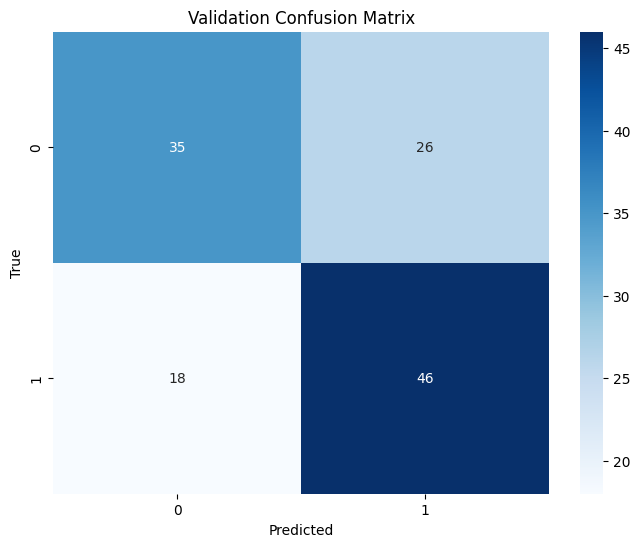

In [28]:
# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    train_acc, train_precision, train_recall, train_f1, train_loss, _ = train_epoch(model, train_loader, optimizer, device, n_train_examples)
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training loss {train_loss} accuracy {train_acc}')
    print(f'Training precision {train_precision} recall {train_recall} f1 {train_f1}')

# Calculate and display evaluation metrics for the entire validation set, including the classification report and confusion matrix
val_acc, val_precision, val_recall, val_f1, val_loss, val_classification_rep, val_cm = eval_model(model, val_loader, device, n_val_examples)

print(f'Validation loss {val_loss} accuracy {val_acc}')
print(f'Validation precision {val_precision} recall {val_recall} f1 {val_f1}')

# Print detailed classification report
print("Classification Report:")
print(val_classification_rep)

# Display confusion matrix for evaluation
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()
